In [65]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd
import os
# Needed for some plotting
import matplotlib.pyplot as plt
from tqdm import tqdm

In [61]:
def list_files(directory):
    output = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            output.append(os.path.join(root, file))
    return output
def run_ora(pathway_names, pathway_db, DEG_df, output_prefix, min_feature_set = 1):
    for cur_pathway_name in pathway_names:
        cur_output_file = output_prefix + "_" + f"{cur_pathway_name}.csv"
        pathway_db_sub = pathway_db[pathway_db['collection']==cur_pathway_name]

        pathway_db_sub = pathway_db_sub[~pathway_db_sub.duplicated(['geneset', 'genesymbol'])]
        cur_db_enr_pvals = dc.get_ora_df(
            df=DEG_df,
            net=pathway_db_sub,
            source='geneset',
            target='genesymbol'
        )
        cur_db_enr_pvals['feature_count'] = cur_db_enr_pvals['Features'].str.split(';').apply(len)
        cur_output_plot_file = output_prefix + "_" + f"{cur_pathway_name}.pdf"
        enr_pvals_sig = cur_db_enr_pvals[(cur_db_enr_pvals["FDR p-value"] < 0.05)]
        enr_pvals_sig = enr_pvals_sig[enr_pvals_sig["feature_count"] > min_feature_set]
        if(enr_pvals_sig.shape[0] == 0):
            print(f"No significantly enriched pathway for {cur_pathway_name}. Next.")
        else:
#             dc.plot_dotplot(enr_pvals_sig, x='Combined score', y = 'Term', s='Odds ratio', c = 'FDR p-value', scale = 0.25, figsize=(7,10))
#             plt.savefig(cur_output_plot_file)
#             plt.close()
            enr_pvals_sig.to_csv(cur_output_file, index=False)
    return enr_pvals_sig

In [62]:
# msigdb = dc.get_resource('MSigDB')


In [63]:
# msigdb.to_csv("/projects/b1169/zzhang/enrichment_ref/msigdb.csv", index=False)
msigdb = pd.read_csv("/projects/b1169/zzhang/enrichment_ref/msigdb.csv")
progeny = dc.get_progeny(top=500)
DEG_root = "/projects/b1042/Gate_Lab/projects/als-project/crispr_clean_final/05.DEG/degs/diagnosis_general/SCT/age_sex"
output_root = "/projects/b1042/Gate_Lab/projects/als-project/crispr_clean_final/08.enrichment/decoupleR"
BH_thres = 0.001
lfc_thres = 0.585
min_DEG_num = 5
pathways_used = [
    'cell_type_signatures',
    'immunesigdb',
    'go_molecular_function',
    'go_biological_process',
    'go_cellular_component',
    'cell_type_signatures',
    'reactome_pathways',
    'hallmark',
    'kegg_pathways'
    ]

In [66]:
all_DEG_files = list_files(DEG_root)
for cur_DEG_file in tqdm(all_DEG_files):
    cur_filename = os.path.basename(cur_DEG_file)
    cur_comp_level = cur_filename.split("___")[0]
    cur_comp_str = cur_filename.split("___")[1]
    cur_comp, _ = os.path.splitext((cur_comp_str.split("__")[1]))
    cur_cell_type = cur_comp_str.split("__")[0]
    cur_out_dir = f"{output_root}/{cur_comp_level}/{cur_cell_type}"
    if not os.path.exists(cur_out_dir):
        os.makedirs(cur_out_dir)
        print(f"Directory '{cur_out_dir}' was created.")

    
    # running ORA
    cur_comp_ct_de_all = pd.read_csv(cur_DEG_file, index_col=0)
    cur_comp_ct_de_up = cur_comp_ct_de_all[(cur_comp_ct_de_all["BH"] < BH_thres) &\
                                           (cur_comp_ct_de_all["avg_log2FC"] > lfc_thres)]
    cur_comp_ct_de_dn = cur_comp_ct_de_all[(cur_comp_ct_de_all["BH"] < BH_thres) & \
                                           (cur_comp_ct_de_all["avg_log2FC"] < -lfc_thres)]
    cur_comp_ct_de_all['sig'] = cur_comp_ct_de_all['avg_log2FC']* (-np.log10(cur_comp_ct_de_all['p_val_adj'] + 1e-3))
    if(cur_comp_ct_de_up.shape[0] < min_DEG_num):
        print("{} has only {} DEG.\nSkipped overrepresentation analysis!".format(cur_filename, str(cur_comp_ct_de_up.shape[0])))
    else:
        cur_comp_ct_de_prefix = cur_out_dir +"/"+ os.path.splitext(cur_comp_str)[0]+"_up"
        _ = run_ora(pathway_names=pathways_used, pathway_db=msigdb, DEG_df=cur_comp_ct_de_up, output_prefix=cur_comp_ct_de_prefix)
        cur_comp_ct_de_prefix = cur_out_dir +"/"+ os.path.splitext(cur_comp_str)[0]+"_dn"
        t = run_ora(pathway_names=pathways_used, pathway_db=msigdb, DEG_df=cur_comp_ct_de_dn, output_prefix=cur_comp_ct_de_prefix)
    
    # run signaling perturbation database 
    try:
        mat = cur_comp_ct_de_all[['sig']].T.rename(index={'sig': cur_cell_type})
        pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
    except ValueError:
        print(f"No sources with more than min_n=5 targets for {cur_cell_type}")
    print("#==========================================================#\n\n")
    

  0%|          | 0/29 [00:00<?, ?it/s]

diagnosis_general___B_memory__als_vs._healthy_control.csv has only 3 DEG.
Skipped overrepresentation analysis!


  3%|▎         | 1/29 [00:02<01:09,  2.49s/it]

#==========================================================#


diagnosis_general___CD8_Proliferating__als_vs._healthy_control.csv has only 0 DEG.
Skipped overrepresentation analysis!


  7%|▋         | 2/29 [00:04<00:53,  1.99s/it]

#==========================================================#


No significantly enriched pathway for cell_type_signatures. Next.


  7%|▋         | 2/29 [00:09<02:09,  4.79s/it]

No significantly enriched pathway for immunesigdb. Next.


KeyboardInterrupt: 

In [53]:
t

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features,feature_count


In [43]:
cur_comp_ct_de_all.head().shape[0]

5

# Old test

In [5]:
msigdb = msigdb[msigdb['collection']=='go_biological_process']
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb.loc[:, 'geneset'] = [name.split('GOBP_')[1] for name in msigdb['geneset']]
msigdb.head()

,genesymbol,collection,geneset
33,MAFF,go_biological_process,EMBRYO_DEVELOPMENT
44,MAFF,go_biological_process,POSITIVE_REGULATION_OF_RNA_METABOLIC_PROCESS
82,MAFF,go_biological_process,REGULATION_OF_EPITHELIAL_CELL_DIFFERENTIATION
94,MAFF,go_biological_process,EMBRYO_DEVELOPMENT_ENDING_IN_BIRTH_OR_EGG_HATC...
108,MAFF,go_biological_process,IN_UTERO_EMBRYONIC_DEVELOPMENT


In [6]:
cur_comp_ct_de_file = "/projects/b1042/Gate_Lab/projects/als-project/crispr_clean_final/05.DEG/degs/diagnosis_general/SCT/age_sex/diagnosis_general___CD16_Mono__als_vs._healthy_control.csv"
cur_comp_ct_de_all = pd.read_csv(cur_comp_ct_de_file, index_col=0)

In [7]:
cur_comp_ct_de_up = cur_comp_ct_de_all[(cur_comp_ct_de_all["BH"] < 1e-3) & (cur_comp_ct_de_all["avg_log2FC"] > 0)]
cur_comp_ct_de_up 
cur_comp_ct_de_dn = cur_comp_ct_de_all[(cur_comp_ct_de_all["BH"] < 1e-3) & (cur_comp_ct_de_all["avg_log2FC"] < 0)]


In [8]:
progeny = dc.get_progeny(top=500)


/home/zzj4347/softwares/anaconda3/envs/decoupler/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
mat = cur_comp_ct_de_all[['avg_log2FC']].T.rename(index={'avg_log2FC': 'CD16 Mono'})

In [10]:
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)


In [19]:
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
CD16 Mono,-0.398525,0.37603,1.494715,0.960677,-6.428676,1.258545,1.878636,-0.088654,1.864352,-2.318113,1.526366,-1.617374,-1.072704,-0.454378


In [32]:
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
CD4_TCM,-0.63071,0.955226,-1.656009,-1.559188,-0.216367,0.172054,-2.26801,2.210637,0.887235,0.643528,1.93962,-2.345277,0.887645,-0.0705


In [12]:
enr_pvals = dc.get_ora_df(
    df=cur_comp_ct_de_up,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)


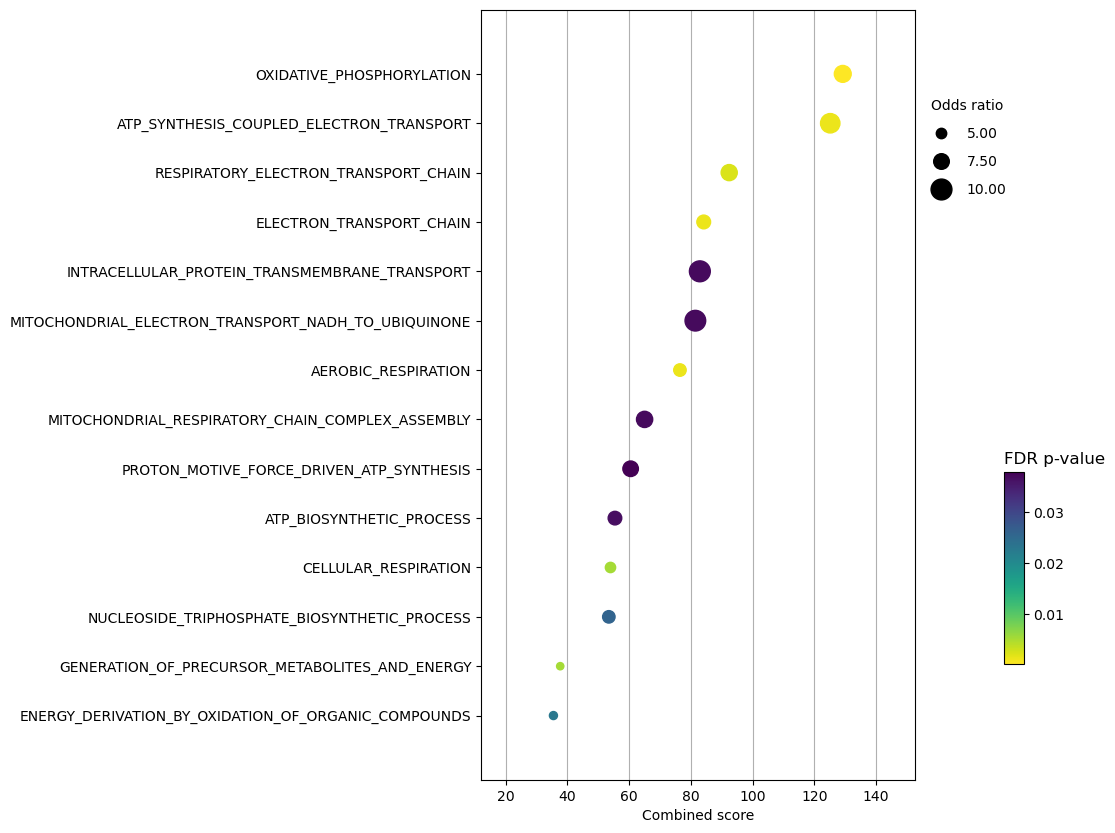

In [13]:
enr_pvals_sig = enr_pvals[enr_pvals["FDR p-value"] < 0.05]
dc.plot_dotplot(enr_pvals_sig, x='Combined score', y = 'Term', s='Odds ratio', c = 'FDR p-value', scale = 0.25, figsize=(7,10))


In [14]:
enr_pvals = dc.get_ora_df(
    df=cur_comp_ct_de_dn,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)


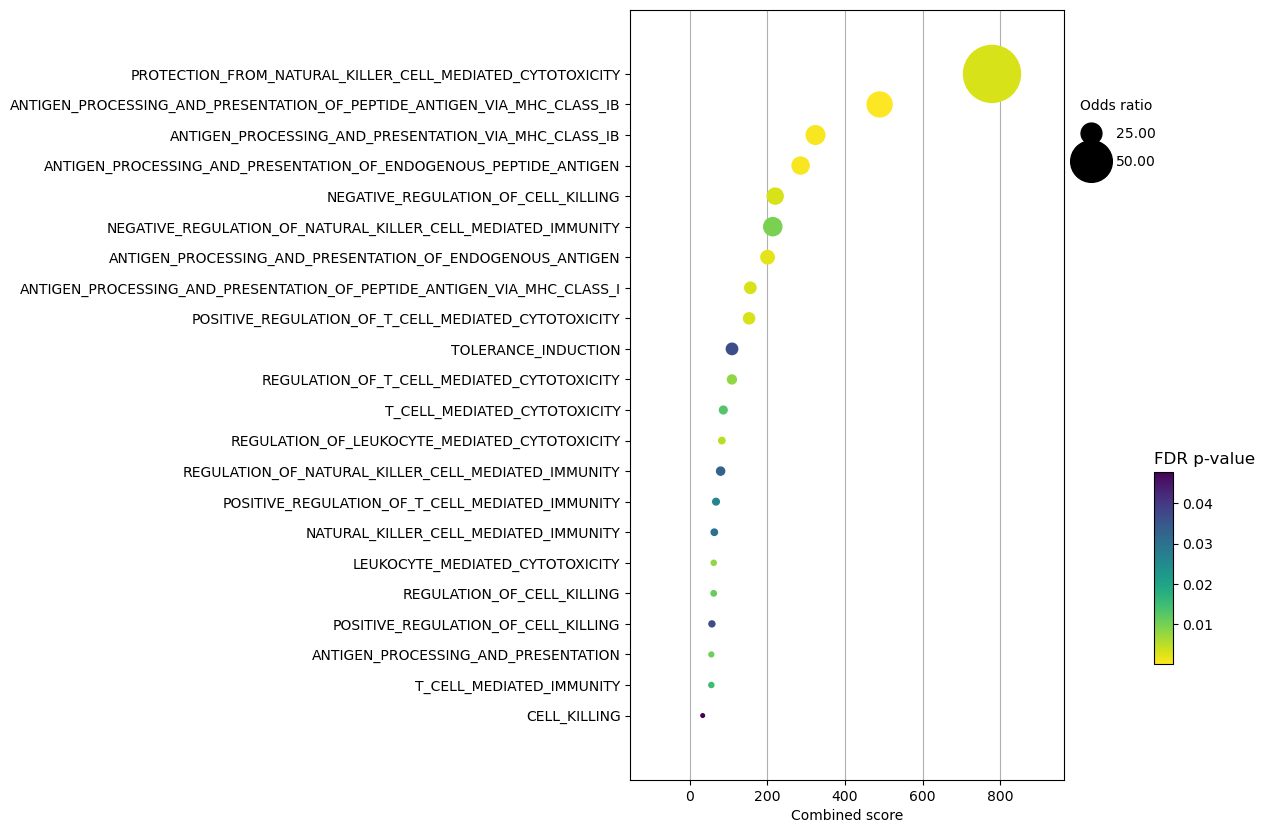

In [15]:
enr_pvals_sig = enr_pvals[enr_pvals["FDR p-value"] < 0.05]
dc.plot_dotplot(enr_pvals_sig, x='Combined score', y = 'Term', s='Odds ratio', c = 'FDR p-value', scale = 0.1, figsize=(7,10))


In [89]:
cur_comp_ct_de_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene_id,BH
CD79B,1.604439e-15,0.223725,0.830,0.774,3.435745e-11,CD79B,2.403449e-12
IGKV4-1,3.683378e-13,0.870764,0.151,0.089,7.887586e-09,IGKV4-1,3.511264e-10
RCSD1,2.481495e-12,0.245252,0.793,0.736,5.313873e-08,RCSD1,2.168413e-09
ABO,5.805665e-11,5.243047,0.015,0.000,1.243225e-06,ABO,3.747251e-08
HNRNPF,4.740218e-10,0.351131,0.411,0.369,1.015070e-05,HNRNPF,2.366949e-07
IGHM,6.792471e-10,0.245999,0.758,0.691,1.454540e-05,IGHM,3.096776e-07
SIT1,4.523595e-09,0.516581,0.210,0.158,9.686826e-05,SIT1,1.581147e-06
CCDC18-AS1,7.095902e-09,0.350217,0.437,0.373,1.519516e-04,CCDC18-AS1,2.400246e-06
CD53,2.464143e-08,0.245824,0.662,0.608,5.276715e-04,CD53,7.382571e-06
CD27,8.353628e-08,0.383060,0.327,0.264,1.788846e-03,CD27,2.246055e-05
